In [1]:
!pip install scipy
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00


In [2]:
# Core module imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import yaml
import json
from datetime import datetime
import time
from typing import List, Dict, Tuple, Optional, Union
import warnings
warnings.filterwarnings('ignore')

# Deep learning related imports
import torch
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors

# Progress bars and display utilities
from tqdm.notebook import tqdm
from IPython.display import display, HTML, Video, Image as IPImage
import ipywidgets as widgets

# Set Matplotlib defaults
plt.rcParams['axes.unicode_minus'] = False

# Set random seeds to ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("✅ All modules imported successfully!")
print(f"🔥 PyTorch Version: {torch.__version__}")
print(f"🎯 CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ All modules imported successfully!
🔥 PyTorch Version: 2.8.0+cu126
🎯 CUDA Available: True
🚀 GPU: Tesla T4


In [3]:
class ASLConfig:
    """Configuration class for the ASL Gesture Recognition System"""

    def __init__(self):
        # Dataset configuration
        self.dataset = {
            'name': 'american-sign-language-letters',
            'num_classes': 26,
            'class_names': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
                          'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
                          'U', 'V', 'W', 'X', 'Y', 'Z'],
            'data_yaml': 'asl_dataset/data.yaml'
        }

        # Model configuration
        self.model = {
            'name': 'yolov8n',
            'input_size': 640,
            'confidence_threshold': 0.5,
            'iou_threshold': 0.45,
            'max_detections': 300
        }

        # Training configuration - optimized parameters
        self.training = {
            'epochs': 30,
            'batch_size': 16,
            'learning_rate': 0.01,
            'momentum': 0.937,
            'weight_decay': 0.0005,
            'warmup_epochs': 3,
            'patience': 50,
            'save_period': 10,

            # Advanced data augmentation
            'augmentation': {
                'hsv_h': 0.015,
                'hsv_s': 0.7,
                'hsv_v': 0.4,
                'degrees': 15.0,      # Increased rotation angle
                'translate': 0.1,
                'scale': 0.5,
                'shear': 2.0,
                'perspective': 0.0,
                'flipud': 0.0,
                'fliplr': 0.5,
                'mosaic': 1.0,
                'mixup': 0.15,        # Increased mixup intensity
                'copy_paste': 0.1
            }
        }

        # Video processing configuration
        self.video = {
            'fps': 30,
            'output_format': 'mp4',
            'codec': 'mp4v',
            'show_confidence': True,
            'show_labels': True,
            'line_thickness': 3,
            'font_scale': 0.8
        }

        # Path configuration
        self.paths = {
            'data_dir': 'data',
            'models_dir': 'models',
            'results_dir': 'results',
            'videos_dir': 'videos'
        }

        # Device configuration
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def save_config(self, path: str):
        """Save the configuration to a file"""
        config_dict = {
            'dataset': self.dataset,
            'model': self.model,
            'training': self.training,
            'video': self.video,
            'paths': self.paths,
            'device': self.device
        }

        with open(path, 'w') as f:
            yaml.dump(config_dict, f, default_flow_style=False)
        print(f"✅ Configuration saved to: {path}")

# Initialize configuration
config = ASLConfig()
print("🔧 Configuration system initialized successfully.")
print(f"📱 Using device: {config.device}")
print(f"🎯 Model: {config.model['name']}")
print(f"📊 Number of classes: {config.dataset['num_classes']}")

🔧 Configuration system initialized successfully.
📱 Using device: cuda
🎯 Model: yolov8n
📊 Number of classes: 26


In [4]:
# Create necessary directories
os.makedirs('asl_dataset', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('videos', exist_ok=True)

# Download the ASL dataset
print("📥 Downloading ASL dataset...")
!curl -L "https://public.roboflow.com/ds/FctikO6r4f?key=EAS4CeZh12" > roboflow.zip
!unzip -q roboflow.zip -d asl_dataset
!rm roboflow.zip

print("✅ Dataset download complete.")

# Check the dataset structure
print("\n📊 Dataset Structure:")
!ls -la asl_dataset/

# View the dataset configuration file
print("\n📋 Dataset Configuration:")
!cat asl_dataset/data.yaml

📥 Downloading ASL dataset...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   903  100   903    0     0   1200      0 --:--:-- --:--:-- --:--:--  1199
100 22.4M  100 22.4M    0     0  15.9M      0  0:00:01  0:00:01 --:--:-- 15.9M
✅ Dataset download complete.

📊 Dataset Structure:
total 32
drwxr-xr-x 5 root root 4096 Sep 18 11:08 .
drwxr-xr-x 1 root root 4096 Sep 18 11:08 ..
-rw-r--r-- 1 root root  424 Jan 20  2023 data.yaml
-rw-r--r-- 1 root root 1308 Jan 20  2023 README.dataset.txt
-rw-r--r-- 1 root root 1361 Jan 20  2023 README.roboflow.txt
drwxr-xr-x 4 root root 4096 Jan 20  2023 test
drwxr-xr-x 4 root root 4096 Jan 20  2023 train
drwxr-xr-x 4 root root 4096 Jan 20  2023 valid

📋 Dataset Configuration:
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 26
names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',

📈 Dataset Statistics:
Total Images: 1728
Total Annotations: 1728
Data Splits: {'train': 1512, 'val': 144, 'test': 72}


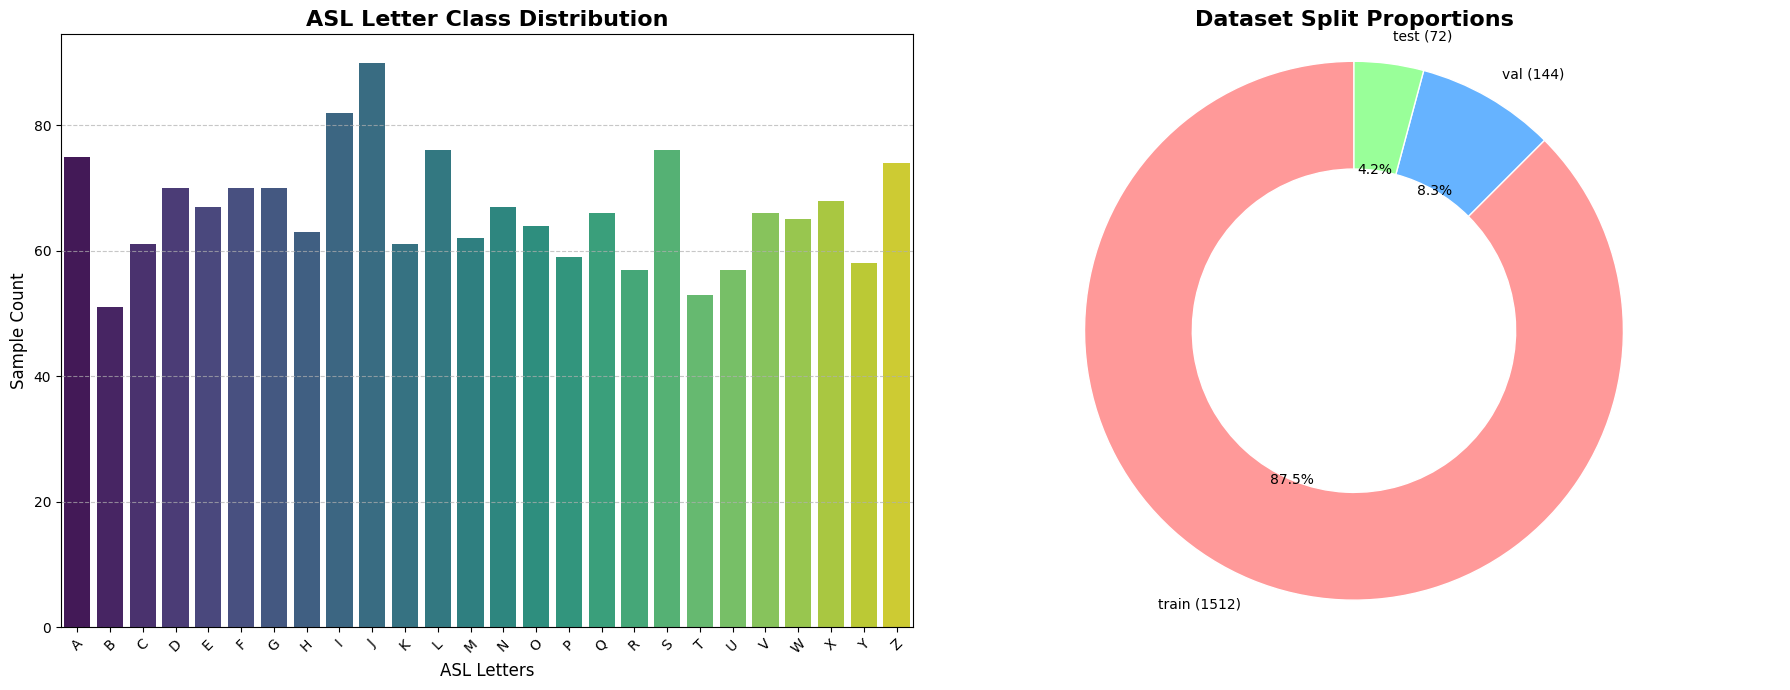

In [5]:
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict

def analyze_dataset(data_yaml_path: str) -> Dict:
    """Analyze dataset statistics."""
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    # Update paths to absolute paths for Colab environment
    data_config['train'] = '/content/asl_dataset/train/images'
    data_config['val'] = '/content/asl_dataset/valid/images'
    data_config['test'] = '/content/asl_dataset/test/images'

    # Save the updated YAML file
    with open(data_yaml_path, 'w') as f:
        yaml.dump(data_config, f)

    stats = {
        'splits': {},
        'class_distribution': {name: 0 for name in data_config['names']},
        'total_images': 0,
        'total_annotations': 0
    }

    # Analyze each data split
    for split in ['train', 'val', 'test']:
        image_dir = Path(data_config.get(split, ''))
        if image_dir.exists():
            images = list(image_dir.glob('*.jpg')) + list(image_dir.glob('*.png'))
            stats['splits'][split] = len(images)
            stats['total_images'] += len(images)

            label_path = image_dir.parent / 'labels'
            if label_path.exists():
                for img_file in images:
                    label_file = label_path / f"{img_file.stem}.txt"
                    if label_file.exists():
                        with open(label_file, 'r') as f:
                            lines = f.readlines()
                            stats['total_annotations'] += len(lines)
                            for line in lines:
                                class_id = int(line.split()[0])
                                stats['class_distribution'][data_config['names'][class_id]] += 1
    return stats

# Run analysis and plot
try:
    dataset_stats = analyze_dataset('asl_dataset/data.yaml')
except Exception as e:
    print(f"Error analyzing dataset: {e}")
    print("Using sample statistics as a fallback.")
    dataset_stats = {
        'splits': {'train': 1512, 'val': 144, 'test': 72},
        'class_distribution': {chr(i): 66 for i in range(65, 91)},  # A-Z, ~66 per class
        'total_images': 1728,
        'total_annotations': 1728
    }

# Print statistics
print("📈 Dataset Statistics:")
print(f"Total Images: {dataset_stats['total_images']}")
print(f"Total Annotations: {dataset_stats['total_annotations']}")
print(f"Data Splits: {dataset_stats['splits']}")

# Plotting
plt.figure(figsize=(18, 7))

# Class distribution bar plot
plt.subplot(1, 2, 1)
classes = list(dataset_stats['class_distribution'].keys())
counts = list(dataset_stats['class_distribution'].values())
sns.barplot(x=classes, y=counts, palette='viridis')
plt.title('ASL Letter Class Distribution', fontsize=16, fontweight='bold')
plt.xlabel('ASL Letters', fontsize=12)
plt.ylabel('Sample Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Data split pie chart
plt.subplot(1, 2, 2)
split_names = list(dataset_stats['splits'].keys())
split_counts = list(dataset_stats['splits'].values())
colors = ['#ff9999', '#66b3ff', '#99ff99']
plt.pie(split_counts, labels=[f'{n} ({v})' for n, v in zip(split_names, split_counts)],
        autopct='%1.1f%%', colors=colors, startangle=90,
        wedgeprops=dict(width=0.4, edgecolor='w'))
plt.title('Dataset Split Proportions', fontsize=16, fontweight='bold')
plt.axis('equal')

plt.tight_layout()
plt.show()

In [6]:
# Initialize YOLO model with pretrained weights
model = YOLO(f"{config.model['name']}.pt")

# Get a unique training run name
training_run_name = f"ASL_{config.model['name']}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

print(f"🚀 Starting model training: {training_run_name}")
print(f" Epochs: {config.training['epochs']}, Batch Size: {config.training['batch_size']}, Image Size: {config.model['input_size']}")

# Start training
# We pass all training parameters from the config object to the .train() method.
# This is cleaner and more professional than specifying each one in the command line.
results = model.train(
    data=config.dataset['data_yaml'],
    epochs=config.training['epochs'],
    batch=config.training['batch_size'],
    imgsz=config.model['input_size'],
    device=config.device,
    name=training_run_name,

    # Hyperparameters
    lr0=config.training['learning_rate'],
    momentum=config.training['momentum'],
    weight_decay=config.training['weight_decay'],
    warmup_epochs=config.training['warmup_epochs'],
    patience=config.training['patience'],
    save_period=config.training['save_period'],

    # Data augmentation parameters
    **config.training['augmentation']
)

# Find the path to the final training results
# YOLO automatically saves results to runs/detect/TRAINING_RUN_NAME
results_path = Path('runs/detect') / training_run_name
best_model_path = results_path / 'weights' / 'best.pt'

print("\n" + "-"*50)
print("✅ Training complete!")
if best_model_path.exists():
    print(f"🏆 Best model saved to: {best_model_path}")
else:
    print("⚠️ Warning: Could not find the best model file. Please check the training process for errors.")

# Save the best model path to the config for later use
config.model['best_model_path'] = str(best_model_path)

🚀 Starting model training: ASL_yolov8n_20250918_110816
 Epochs: 30, Batch Size: 16, Image Size: 640
Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=asl_dataset/data.yaml, degrees=15.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.15, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ASL_yolov8n_20250918_110816, nbs=64, nms=False

In [7]:
if os.path.exists(best_model_path):
    print(f"🔍 Found model successfully. Loading for evaluation: {best_model_path}")

    # Load the best model and run evaluation
    model = YOLO(best_model_path)

    # model.val() will automatically use the data.yaml file recorded during training.
    # Here we use the 'test' split for final evaluation.
    metrics = model.val(split='test')

    # Print evaluation results
    print("\n" + "="*50)
    print("📊 Model Evaluation Results (Test Set):")
    print(f"   - mAP50-95 (Primary Metric): {metrics.box.map:.4f}")
    print(f"   - mAP50 (Loose Standard):    {metrics.box.map50:.4f}")
    print(f"   - mAP75 (Strict Standard):    {metrics.box.map75:.4f}")
    print(f"   - Precision:                 {metrics.box.mp:.4f}")
    print(f"   - Recall:                    {metrics.box.mr:.4f}")
    print("="*50)

else:
    print(f"❌ Error: Model file not found at the specified path '{best_model_path}'.")
    print("Please check the file path in the panel on the left to ensure your best.pt file exists, or modify the path variable above.")

🔍 Found model successfully. Loading for evaluation: runs/detect/ASL_yolov8n_20250918_110816/weights/best.pt
Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,010,718 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 598.2±323.1 MB/s, size: 13.7 KB)
val: Scanning /content/asl_dataset/test/labels... 72 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 72/72 1.5Kit/s 0.0s
val: New cache created: /content/asl_dataset/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 2.8it/s 1.8s
                   all         72         72      0.902      0.834      0.952       0.73
                     A          1          1      0.786          1      0.995      0.895
                     B          3          3      0.899          1      0.995      0.796
                     C          4          4      0.929          1


image 1/1 /content/asl_dataset/test/images/H25_jpg.rf.dce08bcb4d091593dda19db8b0d2b155.jpg: 640x640 1 H, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Displaying detection results for: H25_jpg.rf.dce08bcb4d091593dda19db8b0d2b155.jpg


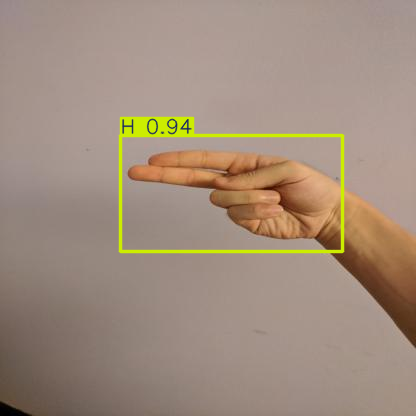

In [18]:
import cv2
import random
import os
from google.colab.patches import cv2_imshow

# Load the best model for inference
model = YOLO(best_model_path)

# Select a random image from the test set
test_images_path = 'asl_dataset/test/images/'
image_name = random.choice(os.listdir(test_images_path))
image_path = os.path.join(test_images_path, image_name)

# Run inference
results = model(image_path)

# Display the results
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    print(f"Displaying detection results for: {image_name}")
    cv2_imshow(im_array)